# Import Necessary Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import warnings

import json
from datetime import datetime
import torch
import torchvision.models as torch_models
from tqdm import tqdm
import numpy as np
from PIL import Image
import copy
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from collections import defaultdict
import random

import models
from models.dynca import DyNCA
from utils.misc.misc import get_start_frame_idx, save_summary
from utils.misc.display_utils import plot_train_log, save_train_image
from utils.misc.preprocess_texture import preprocess_style_image, preprocess_video, select_frame, get_train_image_seq
import matplotlib.pyplot as plt

from utils.loss.loss import Loss

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from utils.misc.video_utils import VideoWriter
from IPython.display import clear_output

torch.backends.cudnn.deterministic = True

# Parameter Setting
Use a class to store all parameters in argparse style

In [2]:
class Args:
    def __init__(self):
        self.img_size = [256, 256] # Controls the image size during training. Corresponds to DyNCA-S/L-img_size in paper
        self.motion_img_size = self.img_size
        self.output_dir = "out/VideoMotion/"
        self.video = True
        self.video_length = 20
        self.video_only = False # only generate video with trained DyNCA model without re-training it
        self.target_dynamics_path = "./data/VideoMotion/Motion/water_3.gif" # /path/to/target_motion_video
        self.target_appearance_path = "./data/VideoMotion/Appearance/water_3.gif" # /path/to/target_appearance_image, can be jpg, png, gif, mp4
        
        """NCA related arguments"""
        self.nca_pool_size = 256
        self.nca_step_range = [80, 144]
        self.nca_inject_seed_step = 8
        self.nca_c_in = 16 # Input channel of DyNCA, DyNCA-S is 12, DyNCA-L is 16
        self.nca_fc_dim = 128 # Dimensionality of Update MLP in DyNCA. DyNCA-S is 96, DyNCA-L is 128
        self.nca_seed_mode = "zeros" # Initialize seed with zero-filled tensor
        self.nca_padding_mode = 'replicate' # Replicate padding when performing Perception, as introduced in Section 3.3
        self.nca_pos_emb = 'CPE' 
        self.nca_perception_scales = [[0]] if self.img_size[0] == 128 else [[0, 1]]
        
        """Loss related arguments"""
        self.appearance_loss_weight = 1.0
        self.appearance_loss_type = 'OT'
        self.texture_model = 'vgg'
        self.video_motion_loss_weight = 1.0
        self.video_motion_loss_type = 'MotionOT'
        self.motion_model_name = 'two_stream_dynamic'
        
        """Train setting"""
        self.nca_warmup_iter = 1000
        self.motion_nca_interval = 64 # Controls how many DyNCA steps equal one frame of motion. 
        self.overflow_loss_weight = 1.0
        self.max_iterations = 5000
        self.save_every = 10
        self.batch_size = 4 if self.img_size[0] == 128 else 3
        self.lr = 1e-3
        self.lr_decay_step = [[1000,2000]]
        self.DEVICE = 'cuda:0'
args = Args()

# Load target motion video and target appearance image. 
Image potentially comes from one frame in a video.

In [3]:
DEVICE = torch.device(args.DEVICE if torch.cuda.is_available() else "cpu")

DynamicTextureLoss = Loss(args)

scale_factor = 1.0
c_out = 3

print('Preparing Style Video')
train_image_seq = preprocess_video(args.target_dynamics_path, img_size=args.img_size)
train_image_seq = train_image_seq.permute(1, 0, 2, 3).to(DEVICE)  # T, C, H, W

(train_image_seq_texture, train_image_texture,
 train_image_texture_save, frame_idx_texture) = get_train_image_seq(
    args,
    flow_func=DynamicTextureLoss.loss_mapper["video_motion"].get_motion_feature_two_frames
)
print(f"Select {frame_idx_texture} frame")

video_length = train_image_seq.shape[0]
video_length_texture = train_image_seq_texture.shape[0]

Image Size For VideoMotionLoss:  [256, 256]
Successfully Loaded two_stream_dynamic model
Preparing Style Video
Select 8 frame


Target Appearance Image: 


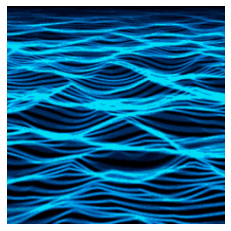

Target Motion Video: 


In [4]:
print("Target Appearance Image: ")
plt.imshow(train_image_texture_save)
plt.axis("off")
plt.show()
print("Target Motion Video: ")
with VideoWriter(autoplay=True) as vid, torch.no_grad():
    for i in range(train_image_seq_texture.shape[0]):
        img = train_image_seq_texture[i].permute(1,2,0).detach().cpu().numpy()
        img = (img + 1.0) / 2.0
        vid.add(img)

# Create output folder

In [5]:
'''Set the size of nca pool'''
nca_size_x, nca_size_y = int(args.img_size[0]), int(args.img_size[1])

nca_perception_scales = args.nca_perception_scales[0]
empty_str = "x"
nca_perception_scales_str = f'per{empty_str.join([str(x) for x in nca_perception_scales])}'
assert nca_perception_scales[0] == 0
nca_min_steps, nca_max_steps = args.nca_step_range
'''Create the log folder'''
motion_img_name = args.target_dynamics_path.split('/')[-1].split('.')[0]
texture_img_name = args.target_appearance_path.split('/')[-1].split('.')[0]
print(f"Motion From {motion_img_name}, Appearance From {texture_img_name}")

output_dir = f'{args.output_dir}/{texture_img_name}/{motion_img_name}/'
"""
Note that this part might encounter permission issue, depending on your system and setting.
Call sudo if necessary. 
"""
if (not args.video_only):
    os_output_dir = "\ ".join(output_dir.split(" "))
    os.system(f"mkdir -p {os_output_dir}")
    os.system(f"chmod 777 {os_output_dir}")
    os.system(f"rm -rf {os_output_dir}/*")

train_image_texture_save.save(f"{output_dir}/select_frame.png")

Motion From water_3, Appearance From water_3


# Initialize DyNCA, including model and pool.

In [6]:
nca_model_list = []
nca_model = DyNCA(c_in=args.nca_c_in, c_out=c_out, fc_dim=args.nca_fc_dim,
                  seed_mode=args.nca_seed_mode,
                  pos_emb=args.nca_pos_emb, padding_mode=args.nca_padding_mode,
                  perception_scales=nca_perception_scales,
                  device=DEVICE)

with torch.no_grad():
    nca_pool = nca_model.seed(args.nca_pool_size, size=(nca_size_x, nca_size_y))
print(f'NCA Pool shape: ', nca_pool.shape)

param_n = sum(p.numel() for p in nca_model.parameters())
print('NCA param count:', param_n) # 0.01M for DyNCA-L, 0.006M for DyNCA-S

args_log = copy.deepcopy(args.__dict__)
del args_log['DEVICE']
if ('target_motion_vec' in args_log):
    del args_log['target_motion_vec']
with open(f'{output_dir}/args.txt', 'w') as f:
    json.dump(args_log, f, indent=2)

if (not args.video_only):
    pbar = tqdm(range(args.max_iterations), ncols=256)
else:
    pbar = tqdm(range(0))
optimizer = torch.optim.Adam(nca_model.parameters(), lr=args.lr)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                    args.lr_decay_step[0],
                                                    0.3)

NCA Pool shape:  torch.Size([256, 16, 256, 256])
NCA param count: 10640


  0%|                                                                                                                                                                                                                                  | 0/5000 [00:00<?, ?it/s]

# Training code

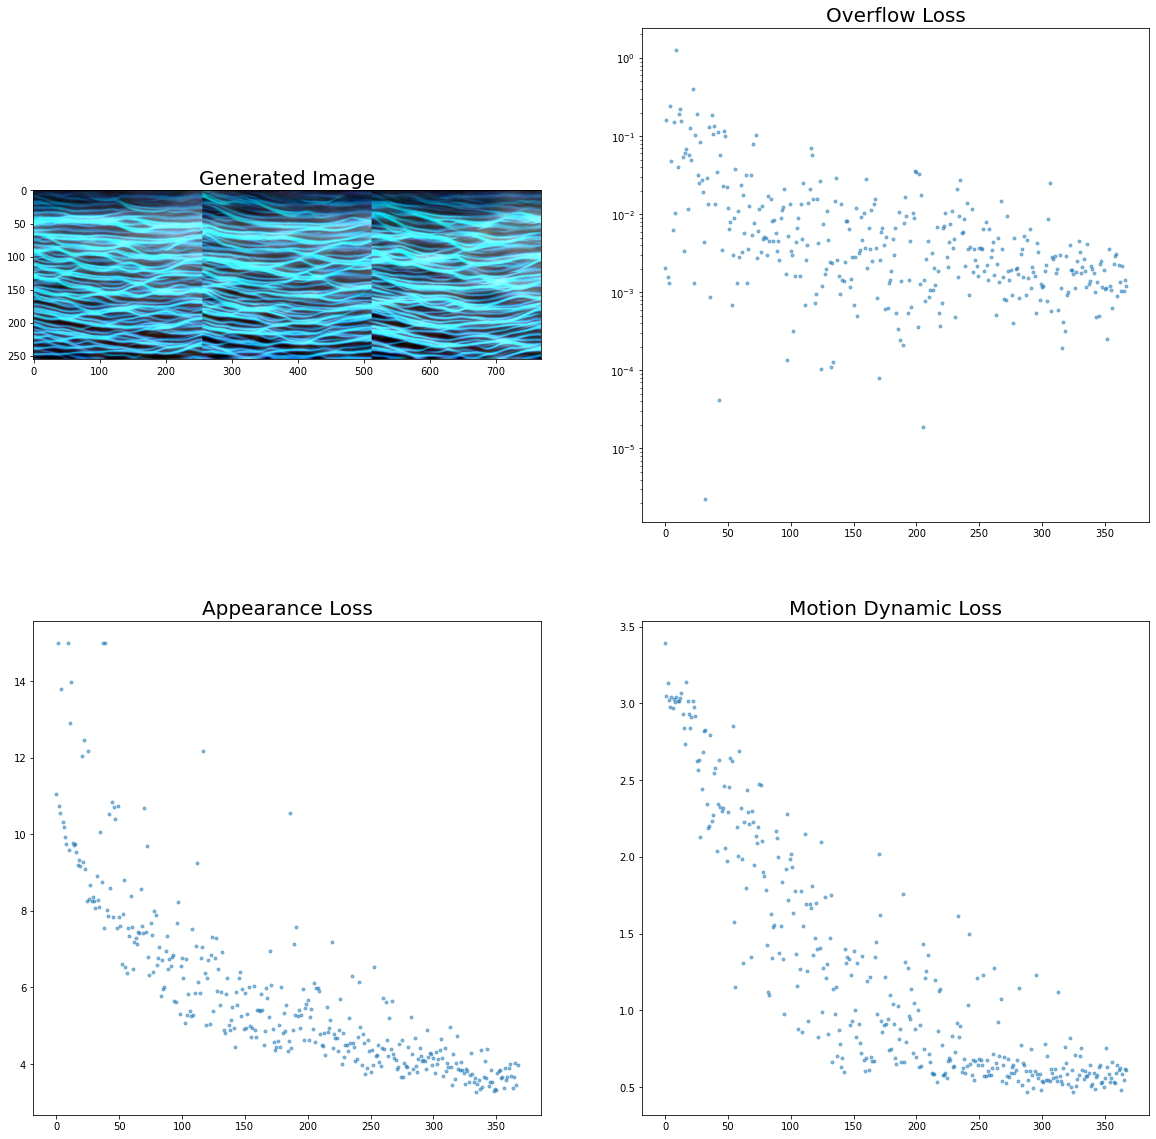

  9%|████████████▏                                                                                                                                | 430/5000 [06:11<1:01:16,  1.24it/s, overflow=0.00518, appearance=3.85, video_motion=0.529, lr=0.001, fidx=2]

In [ ]:
input_dict = {}  # input dictionary for loss computing

loss_log_dict = defaultdict(list)

init_loss_weight = 5.0
DynamicTextureLoss.set_loss_weight([args.video_motion_loss_weight], loss_name='video_motion',
                                   loss_num=init_loss_weight)

for i in pbar:
    np.random.seed(i + 424)
    torch.manual_seed(i + 424)
    torch.cuda.manual_seed_all(i + 424)
    with torch.no_grad():
        batch_idx = np.random.choice(args.nca_pool_size, args.batch_size, replace=False)
        input_states = nca_pool[batch_idx]
        seed_injection = False
        if i % args.nca_inject_seed_step == 0:
            seed_injection = True
            seed_inject = nca_model.seed(1, size=(nca_size_x, nca_size_y))
            input_states[:1] = seed_inject[:1]

    step_n = np.random.randint(nca_min_steps, nca_max_steps)
    nca_state, nca_feature, middle_feature_list = nca_model.forward_nsteps(input_states, step_n,
                                                                           return_middle_feature=True)
    input_dict['nca_state'] = nca_state

    '''Get Image Sequence from NCA iterations'''
    nca_video_feature_list = middle_feature_list[::args.motion_nca_interval]
    batch_minus = 0
    if (seed_injection == True):
        batch_minus = 0
        nca_video_feature_list_trunc = [x for x in nca_video_feature_list]
    else:
        nca_video_feature_list_trunc = nca_video_feature_list
    generated_image_list = [z for z in nca_video_feature_list]
    generated_image_list_trunc = [z for z in nca_video_feature_list_trunc]
    image_list_length = len(generated_image_list)
    input_dict['generated_image_list'] = generated_image_list
    input_dict['generated_image_list_motion'] = generated_image_list_trunc

    '''Build target image sequence from train_image_seq_texture'''

    idx_vid = get_start_frame_idx(video_length, image_list_length)
    target_image_list = []
    for j in range(image_list_length + batch_minus):
        target_image_list.append(
            train_image_seq_texture[frame_idx_texture:frame_idx_texture + 1].repeat(args.batch_size, 1, 1,
                                                                                    1))

    input_dict['target_image_list'] = target_image_list

    generated_image = nca_feature
    with torch.no_grad():
        generated_image_vis = generated_image.clone()
        generated_image_vis = (generated_image_vis + 1.0) / 2.0

    '''Construct input dictionary for loss computation'''
    if (args.video_motion_loss_weight > 0):
        target_motion_image_list = []
        if (idx_vid > video_length):
            idx_vid = 0
        for j in range(idx_vid, idx_vid + image_list_length):
            target_motion_image_list.append(train_image_seq[j:j + 1].repeat(args.batch_size - batch_minus, 1, 1, 1))

        input_dict['target_motion_image_list'] = target_motion_image_list

    batch_loss, batch_loss_log_dict, summary = DynamicTextureLoss(input_dict, return_summary=False)

    for loss_name in batch_loss_log_dict:
        if (seed_injection == False):
            loss_log_dict[loss_name].append(min(batch_loss_log_dict[loss_name], 15.0))

    if (i == args.nca_warmup_iter and args.video_motion_loss_weight > 0.0): 
        # This is the part for adjusting the weight of video motion training. See Appendix Section 3.2.1
        DynamicTextureLoss.set_loss_weight(loss_name='video_motion', loss_num=args.video_motion_loss_weight,
                                           medium_mt=np.median(loss_log_dict[
                                                                   'video_motion']))  # np.median(loss_log_dict['video_motion'])
        with torch.no_grad():
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        del nca_model
        del batch_loss
        del optimizer

        nca_model = DyNCA(c_in=args.nca_c_in, c_out=c_out, fc_dim=args.nca_fc_dim,
                          seed_mode=args.nca_seed_mode,
                          pos_emb=args.nca_pos_emb, padding_mode=args.nca_padding_mode,
                          perception_scales=nca_perception_scales,
                          device=DEVICE)

        with torch.no_grad():
            nca_pool = nca_model.seed(args.nca_pool_size, size=(nca_size_x, nca_size_y))

        optimizer = torch.optim.Adam(nca_model.parameters(), lr=args.lr)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                            args.lr_decay_step[0],
                                                            0.3)
        continue

    with torch.no_grad():
        anomaly_loss = False
        batch_loss.backward()
        if (torch.isnan(batch_loss)):
            with open(f'{output_dir}/train_failed.txt', 'w') as f:
                f.write(f'Epochs {i}')
            print('Loss is NaN. Train Failed. Exit.')
            exit()
        if (batch_loss_log_dict['appearance'] > 50.0):
            anomaly_loss = True
        for p_name, p in nca_model.named_parameters():
            p.grad /= (p.grad.norm() + 1e-8)  # normalize gradients
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()

        if (anomaly_loss == False):
            nca_pool[batch_idx] = nca_state
        else:
            nca_pool[batch_idx] = nca_model.seed(args.batch_size, size=(nca_size_x, nca_size_y))
        if (i % 5 == 0):
            display_dict = copy.deepcopy(batch_loss_log_dict)
            display_dict['lr'] = lr_scheduler.get_lr()[0]
            display_dict['fidx'] = idx_vid
            pbar.set_postfix(display_dict)
        if i % args.save_every == 0:
            clear_output(True)
            img_show = save_train_image(generated_image_vis.detach().cpu().numpy(), f"{output_dir}/step{i}.jpg", return_img = True)

            '''Dict: loss log, yscale to log (True/False), ylim (True/False)'''
            plot_log_dict = {}
            num_plots = 2

            plot_log_dict['Overflow Loss'] = (loss_log_dict['overflow'], True, True)
            plot_log_dict['Appearance Loss'] = (loss_log_dict['appearance'], False, True)
            # plot_train_log(plot_log_dict, num_plots, save_path=f"{output_dir}/losses.jpg")

            if "video_motion" in loss_log_dict:
                save_summary(summary, save_train_image, output_dir, i=i)

                plot_log_dict = {}
                plot_log_dict['Motion Texture Loss'] = (loss_log_dict['video_motion'], False, False)
                # plot_train_log(plot_log_dict, 1, save_path=f"{output_dir}/losses_video_motion.jpg")
            plt.figure(figsize=(20, 20))
            plt.subplot(2,2,1)
            plt.title("Generated Image", fontsize = 20)
            plt.imshow(img_show)
            
            plt.subplot(2,2,2)
            plt.title("Overflow Loss", fontsize = 20)
            plt.plot(loss_log_dict['overflow'], '.', alpha = 0.5)
            plt.yscale('log')
            
            plt.subplot(2,2,3)
            plt.title("Appearance Loss", fontsize = 20)
            plt.plot(loss_log_dict['appearance'], '.',alpha = 0.5)
            
            plt.subplot(2,2,4)
            plt.title("Motion Dynamic Loss", fontsize = 20)
            plt.plot(loss_log_dict['video_motion'], '.', alpha = 0.5)
            plt.show()

if (not args.video_only):
    torch.save(nca_model, f"{output_dir}/model.pth")
else:
    nca_model = torch.load(f"{output_dir}/model.pth")

# Generate Video
Can also record the loss during test. This is for quantitative experiments.

In [ ]:
def synthesize_video(args, nca_model, video_length, output_dir, train_image_seq_texture, train_image_seq,
                     video_name='video', nca_step=32, record_loss=False, loss_class=None, seed_size=[256, 256], fps=25):
    motion_video_length, texture_videl_length = len(train_image_seq), len(train_image_seq_texture)
    """
    Parameters for Post-training Control:
        nca_step: Speed Control
        seed_size: Image Size Control
        More post-training control can be seen in our online demo: https://dynca.github.io/
    """
    with VideoWriter(filename=f"{output_dir}/{video_name}.mp4", fps=fps, autoplay=True) as vid, torch.no_grad():
        h = nca_model.seed(1, size=seed_size)
        if (record_loss):
            assert loss_class is not None
            prev_z = None
            total_video_motion_loss_avg = 0.0
            total_appearance_loss_avg = 0.0
        for k in tqdm(range(int(video_length)), desc="Making the video..."):
            step_n = nca_step
            nca_state, nca_feature = nca_model.forward_nsteps(h, step_n)

            z = nca_feature

            if (record_loss):
                input_dict = {}
                cur_video_motion_loss_avg = 0.0
                cur_appearance_loss_avg = 0.0

                if (prev_z is None):
                    prev_z = z
                else:
                    generated_image_list = [prev_z, z]
                    input_dict['generated_image_list'] = [generated_image_list[-1]]
                    input_dict['generated_image_list_motion'] = generated_image_list
                    for j in range(texture_videl_length):
                        '''Compute Texture loss between current generated image and all texture frames'''
                        target_image_list = []
                        target_image_list.append(train_image_seq_texture[j:j + 1])
                        input_dict['target_image_list'] = target_image_list
                        appearance_loss, _, _ = loss_class.loss_mapper['appearance'](input_dict, return_summary=False)
                        cur_appearance_loss_avg += appearance_loss.item()
                    cur_appearance_loss_avg /= texture_videl_length

                    for j in range(motion_video_length - 1):
                        target_motion_image_list = []
                        target_motion_image_list.append(train_image_seq[j:j + 1])
                        target_motion_image_list.append(train_image_seq[j + 1:j + 2])
                        input_dict['target_motion_image_list'] = target_motion_image_list
                        video_motion_loss, _, _ = loss_class.loss_mapper['video_motion'](input_dict,
                                                                                             return_summary=False)
                        cur_video_motion_loss_avg += video_motion_loss.item()
                    cur_video_motion_loss_avg /= (motion_video_length - 1)

                    total_appearance_loss_avg += cur_appearance_loss_avg
                    total_video_motion_loss_avg += cur_video_motion_loss_avg

                    prev_z = z

            h = nca_state

            img = z.detach().cpu().numpy()[0]
            img = img.transpose(1, 2, 0)

            img = np.clip(img, -1.0, 1.0)
            img = (img + 1.0) / 2.0
            vid.add(img)
        if (record_loss):
            total_appearance_loss_avg /= float(video_length)
            total_video_motion_loss_avg /= float(video_length)
            print("Average Appearance Loss: ", total_appearance_loss_avg)
            print("Average Motion Loss: ", total_video_motion_loss_avg)
            with open(f'{output_dir}/final_loss_test.txt', 'w') as f:
                f.write(f'{total_appearance_loss_avg, total_video_motion_loss_avg}')


nca_model.eval()
synthesize_video(args, nca_model, video_length=args.video_length * 20,
                 output_dir=output_dir,
                 train_image_seq_texture=train_image_seq_texture,
                 train_image_seq=train_image_seq, video_name='video',
                 nca_step=args.motion_nca_interval // 2,
                 record_loss=True, loss_class=DynamicTextureLoss,
                 seed_size=(nca_size_x, nca_size_y), fps=25)

# Generate videos with different size as during training WITHOUT re-training.

In [ ]:
synthesize_video(args, nca_model, video_length=args.video_length * 20,
                 output_dir=output_dir,
                 train_image_seq_texture=train_image_seq_texture,
                 train_image_seq=train_image_seq, video_name='video_large',
                 nca_step=args.motion_nca_interval // 2,
                 record_loss=False, loss_class=DynamicTextureLoss,
                 seed_size=(nca_size_x * 2, nca_size_y * 2), fps=25)